# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Чтобы сдать проект успешно, нужно довести метрику до 0.59. 

Дополнительно нужно измерить *AUC-ROC* и сравнить её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Признаки датафрейма:
RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — количество недвижимости у клиента
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата


Целевой признак датафрейма:
Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Сделаем все названия столбцов строчными, чтобы не было лишних промахов при наборе заглавного или строчного символа. Видим, что в есть ~ 1000 пропущенных значений в столбце о наличии недвижимости. Менять на нули не стоит - таким образом, исказится адекватность данных и их дальнейший анализ, а потом это всё повляет на доходность банка, которая будет измеряться сотнями тысяч ден. единиц: "Assumptions are the mother of all mistakes", как говорится в цензурном варианте цитаты. В данном случае, разумным будет решение удалить те строки, у которых значение Nan'ы. Да, будет потеряна ~ 1/10 часть информации, однако, данные будут корректными. Какие ещё манипуляции произведём с датой: уберём столбцы с фамилией,порядковым номером клинета и его ID - они могут повлиять на качество обучения моделей, плюс, наличие всех трёх показателей в данной ситуации можно считать избыточным.

In [5]:
data.columns = map(str.lower, data.columns)

In [6]:
data.dropna(subset = ['tenure'], inplace = True)

In [7]:
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

In [8]:
data = data.drop(['surname', 'rownumber', 'customerid'], axis=1)

Приводим все флоаты в целочисленные значения, чтобы модели о них не спотыкались.

In [9]:
data['balance'] = data['balance'].astype('int')
data['tenure'] = data['tenure'].astype('int')
data['estimatedsalary'] = data['estimatedsalary'].astype('int')

Проверка:

In [10]:
data.dtypes

creditscore         int64
geography          object
gender             object
age                 int64
tenure              int64
balance             int64
numofproducts       int64
hascrcard           int64
isactivemember      int64
estimatedsalary     int64
exited              int64
dtype: object

# 2. Исследование задачи

Проанализируем баланс классов:

In [11]:
frequency = data['exited'].value_counts(normalize= True)
frequency


0    0.796062
1    0.203938
Name: exited, dtype: float64

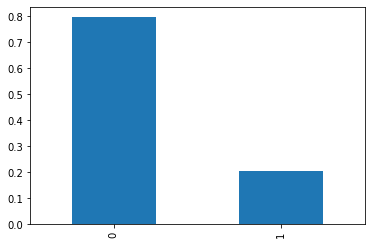

In [12]:
frequency.plot(kind='bar')
plt.show()

Очевидно, что классы несбалансированы: пользователи уходят в 20% процентах случаев, или "1" больше "0" в 4 раза. Однако, продолжим изучать модели на этом шаге без учёта дисбаланса классов.

Создадим пару функций, которая облегчит в дальнейшем объём и сэкономит время набора кода.

In [13]:
# возвращение целевого признака и признаков для обучения модели
def tf(data, target_column='exited'):  
    
    target = data[target_column]
    features = data.drop(target_column, axis=1)
    return target, features

In [14]:
# разделение даты на обуч., валидац. и тест. выборки в пропорции 6/2/2
def split_data(features, target):
    
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.4, random_state=12345
    )

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=0.5, random_state=12345
    )
    
# масштабирование количественных признаков
    scaler = StandardScaler()
    numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_valid, features_test, target_train, target_valid, target_test

In [15]:
# возвращение обученной модели
def train_and_predict(data, model, log_prefix='', samplefunc=None, test=False):
    
    target, features = tf(data)
    features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
    
    if samplefunc:
        features_train, target_train = samplefunc(features_train, target_train)
    
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'{log_prefix}F1-score на валидационной выборке: {f1_score(target_valid, predicted_valid)}')
    
    if test:
        predictions_test = model.predict(features_test)
        print(f'{log_prefix}F1-score на тестовой выборке: {f1_score(target_test, predicted_test)}')
    
    return model

Применим технику прямого кодирования, чтобы преобразовать категориальные признаки в численные для логистической регрессии.

In [16]:
data_ohe = pd.get_dummies(data, drop_first=True)

In [17]:
model = LogisticRegression(solver='liblinear', random_state=12345)
train_and_predict(data_ohe, model)

F1-score на валидационной выборке: 0.30400000000000005


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Применим технику порядкового кодирования для категориальных признаков в работе с моделями дерева решение и случайного леса.

In [18]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data), columns=data.columns)

Дерево решений:

In [19]:
for i in range(1, 31, 1):
    model = DecisionTreeClassifier(max_depth=i, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {i}:\t')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


max_depth 1:	F1-score на валидационной выборке: 0.0
max_depth 2:	F1-score на валидационной выборке: 0.5304878048780488
max_depth 3:	F1-score на валидационной выборке: 0.3726708074534161
max_depth 4:	F1-score на валидационной выборке: 0.5414551607445008
max_depth 5:	F1-score на валидационной выборке: 0.5513698630136986
max_depth 6:	F1-score на валидационной выборке: 0.5106382978723404
max_depth 7:	F1-score на валидационной выборке: 0.5315161839863713
max_depth 8:	F1-score на валидационной выборке: 0.5085910652920962
max_depth 9:	F1-score на валидационной выборке: 0.515702479338843
max_depth 10:	F1-score на валидационной выборке: 0.5421133231240429
max_depth 11:	F1-score на валидационной выборке: 0.5164179104477611
max_depth 12:	F1-score на валидационной выборке: 0.5
max_depth 13:	F1-score на валидационной выборке: 0.4922206506364922
max_depth 14:	F1-score на валидационной выборке: 0.4798927613941019
max_depth 15:	F1-score на валидационной выборке: 0.4600811907983762
max_depth 16:	F1-sco

Лучший показатель F1 получился при глубине в 5 деревьев - 0.5513. Посмотрим, какой F1 получится с такой глубиной, когда примением модель случайного леса.

Случайный лес:

In [20]:
for i in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=i, max_depth=5, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {i}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.44047619047619047
n_estimators = 20:	F1-score на валидационной выборке: 0.4639376218323587
n_estimators = 30:	F1-score на валидационной выборке: 0.4799999999999999
n_estimators = 40:	F1-score на валидационной выборке: 0.5055762081784386
n_estimators = 50:	F1-score на валидационной выборке: 0.5111940298507462
n_estimators = 60:	F1-score на валидационной выборке: 0.5102420856610801
n_estimators = 70:	F1-score на валидационной выборке: 0.5257352941176471
n_estimators = 80:	F1-score на валидационной выборке: 0.5230202578268877
n_estimators = 90:	F1-score на валидационной выборке: 0.5257352941176471
n_estimators = 100:	F1-score на валидационной выборке: 0.5220588235294118
n_estimators = 110:	F1-score на валидационной выборке: 0.5247706422018349
n_estimators = 120:	F1-score на валидационной выборке: 0.5175600739371534
n_estimators = 130:	F1-score на валидационной выборке: 0.5175600739371534
n_estimators = 140:	F1-score на валидационной 

Глубина в 5 деревьев мне кажется недостаточной, точнее, с таким значением - надо посмотреть ещё и другие альтернативные варианты гиперпараметра, с помощью эвристики подкрутим глубину, стараясь получить максимальное значение F1. Покрутив значение "за кадром" вышла на глубину в 10 деревьев, при 30 в значении количества деревьев выходит max значение F1 ~ 0.58305. Подтверим это вычислениями:

In [21]:
for i in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=i, max_depth=10, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {i}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.5690235690235691
n_estimators = 20:	F1-score на валидационной выборке: 0.5724020442930153
n_estimators = 30:	F1-score на валидационной выборке: 0.5830508474576271
n_estimators = 40:	F1-score на валидационной выборке: 0.5733788395904437
n_estimators = 50:	F1-score на валидационной выборке: 0.5660377358490567
n_estimators = 60:	F1-score на валидационной выборке: 0.5655172413793104
n_estimators = 70:	F1-score на валидационной выборке: 0.5660377358490567
n_estimators = 80:	F1-score на валидационной выборке: 0.5660377358490567
n_estimators = 90:	F1-score на валидационной выборке: 0.5565217391304348
n_estimators = 100:	F1-score на валидационной выборке: 0.5640138408304498
n_estimators = 110:	F1-score на валидационной выборке: 0.5555555555555556
n_estimators = 120:	F1-score на валидационной выборке: 0.5555555555555556
n_estimators = 130:	F1-score на валидационной выборке: 0.5580589254766032
n_estimators = 140:	F1-score на валидационной в

# 3. Борьба с дисбалансом

Сбалансируем классы с помощью аргумента class_weight, начнём смотреть результаты на регрессии:

In [22]:
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)
train_and_predict(data_ohe, model)

F1-score на валидационной выборке: 0.509731232622799


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Значение F1 увеличилось с ~0.304 до ~0.509.

Дерево решений:

In [23]:
for i in range(1, 31, 1):
    model = DecisionTreeClassifier(class_weight='balanced', max_depth=i, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'max_depth {i}:\t')

max_depth 1:	F1-score на валидационной выборке: 0.5065856129685917
max_depth 2:	F1-score на валидационной выборке: 0.5297619047619048
max_depth 3:	F1-score на валидационной выборке: 0.548936170212766
max_depth 4:	F1-score на валидационной выборке: 0.5045492142266335
max_depth 5:	F1-score на валидационной выборке: 0.5758928571428572
max_depth 6:	F1-score на валидационной выборке: 0.574370709382151
max_depth 7:	F1-score на валидационной выборке: 0.5118577075098815
max_depth 8:	F1-score на валидационной выборке: 0.5362637362637362
max_depth 9:	F1-score на валидационной выборке: 0.4965104685942173
max_depth 10:	F1-score на валидационной выборке: 0.4988962472406181
max_depth 11:	F1-score на валидационной выборке: 0.49002217294900213
max_depth 12:	F1-score на валидационной выборке: 0.4889406286379511
max_depth 13:	F1-score на валидационной выборке: 0.4720194647201946
max_depth 14:	F1-score на валидационной выборке: 0.48152866242038217
max_depth 15:	F1-score на валидационной выборке: 0.473061

С помощью балансировки на шиномонтажке (зачёркнуто) 0.5513 получилось поднять до 0.5758 при 5 глубине в 5 единици деревьем. В модели случайного леса будем так же настраивать глубину деревьев с помощью эвристики, а пока стартанём с показателя в 5 деревьев.

Модель случайного леса:

In [24]:
for i in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=i, max_depth=5, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {i}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.5825242718446602
n_estimators = 20:	F1-score на валидационной выборке: 0.5925925925925927
n_estimators = 30:	F1-score на валидационной выборке: 0.5995670995670995
n_estimators = 40:	F1-score на валидационной выборке: 0.6067907995618839
n_estimators = 50:	F1-score на валидационной выборке: 0.5961123110151187
n_estimators = 60:	F1-score на валидационной выборке: 0.5911542610571737
n_estimators = 70:	F1-score на валидационной выборке: 0.593311758360302
n_estimators = 80:	F1-score на валидационной выборке: 0.5941872981700754
n_estimators = 90:	F1-score на валидационной выборке: 0.5976267529665589
n_estimators = 100:	F1-score на валидационной выборке: 0.5894962486602358
n_estimators = 110:	F1-score на валидационной выборке: 0.5913978494623655
n_estimators = 120:	F1-score на валидационной выборке: 0.5921192758253462
n_estimators = 130:	F1-score на валидационной выборке: 0.592274678111588
n_estimators = 140:	F1-score на валидационной выб

Покрутив снова "за кадром" глубину получили максимальное значение F1 в 0.6390 при значении в 11 единиц глубины деревьев, а количестве - в 30. Подтвердим сказанное:

In [25]:
for i in range(10, 201, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=i, max_depth=11, random_state=12345)
    train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {i}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.5956873315363881
n_estimators = 20:	F1-score на валидационной выборке: 0.6282578875171468
n_estimators = 30:	F1-score на валидационной выборке: 0.6390041493775934
n_estimators = 40:	F1-score на валидационной выборке: 0.6358543417366946
n_estimators = 50:	F1-score на валидационной выборке: 0.6362339514978601
n_estimators = 60:	F1-score на валидационной выборке: 0.6311360448807855
n_estimators = 70:	F1-score на валидационной выборке: 0.6302521008403361
n_estimators = 80:	F1-score на валидационной выборке: 0.6283309957924264
n_estimators = 90:	F1-score на валидационной выборке: 0.6276150627615062
n_estimators = 100:	F1-score на валидационной выборке: 0.6203966005665723
n_estimators = 110:	F1-score на валидационной выборке: 0.6182336182336182
n_estimators = 120:	F1-score на валидационной выборке: 0.6201991465149359
n_estimators = 130:	F1-score на валидационной выборке: 0.6193181818181819
n_estimators = 140:	F1-score на валидационной в

In [26]:
model = LGBMClassifier(class_weight='balanced', random_state=12345)
train_and_predict(data_ordinal, model, log_prefix=f'n_estimators = {i}:\t')

n_estimators = 200:	F1-score на валидационной выборке: 0.6223277909738718


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=12345, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Лучший показатель по F1 показала модель случайного леса с class_weight='balanced', её и будем тестировать.

Применим технику уменьшения выборки - downsampling:

In [27]:
def downsample(features, target, fraction = 0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones]
    )
    
    return features_downsampled, target_downsampled

In [28]:
model = LogisticRegression(solver='liblinear', random_state=12345)
train_and_predict(data_ohe, model, samplefunc=downsample)

F1-score на валидационной выборке: 0.48878205128205127


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

Значение F1 упало: 0.509 vs 0.488

In [29]:
for max_depth in range(1, 31, 1):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'max_depth {max_depth}:\t')


max_depth 1:	F1-score на валидационной выборке: 0.49555950266429843
max_depth 2:	F1-score на валидационной выборке: 0.5100788781770377
max_depth 3:	F1-score на валидационной выборке: 0.5644599303135889
max_depth 4:	F1-score на валидационной выборке: 0.5242399342645849
max_depth 5:	F1-score на валидационной выборке: 0.5529197080291971
max_depth 6:	F1-score на валидационной выборке: 0.533003300330033
max_depth 7:	F1-score на валидационной выборке: 0.5178268251273345
max_depth 8:	F1-score на валидационной выборке: 0.5238938053097345
max_depth 9:	F1-score на валидационной выборке: 0.5221238938053097
max_depth 10:	F1-score на валидационной выборке: 0.5340699815837937
max_depth 11:	F1-score на валидационной выборке: 0.5113438045375218
max_depth 12:	F1-score на валидационной выборке: 0.5057880676758681
max_depth 13:	F1-score на валидационной выборке: 0.5044563279857398
max_depth 14:	F1-score на валидационной выборке: 0.497391304347826
max_depth 15:	F1-score на валидационной выборке: 0.4942630

Также падение: 0.5758 vs 0.5644

In [30]:
for estim in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=19, random_state=12345)
    train_and_predict(data_ordinal, model, samplefunc=downsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.5424354243542435
n_estimators = 20:	F1-score на валидационной выборке: 0.5514184397163121
n_estimators = 30:	F1-score на валидационной выборке: 0.544157002676182
n_estimators = 40:	F1-score на валидационной выборке: 0.549469964664311
n_estimators = 50:	F1-score на валидационной выборке: 0.5517241379310345
n_estimators = 60:	F1-score на валидационной выборке: 0.5513608428446005
n_estimators = 70:	F1-score на валидационной выборке: 0.5640569395017794
n_estimators = 80:	F1-score на валидационной выборке: 0.559576345984113
n_estimators = 90:	F1-score на валидационной выборке: 0.5530035335689045
n_estimators = 100:	F1-score на валидационной выборке: 0.5601404741000878
n_estimators = 110:	F1-score на валидационной выборке: 0.5638766519823789
n_estimators = 120:	F1-score на валидационной выборке: 0.5628318584070797
n_estimators = 130:	F1-score на валидационной выборке: 0.5646017699115045
n_estimators = 140:	F1-score на валидационной выбо

Я снова покрутила вручную глубину деревьев, подняв её, но смогла добиться только значения ~ 0.5759. Причем, значение не подымалось и не опускалось драматически, даже если ранжирование настройки глубины были 19, 23, 27, 35 соответственно. Как будто значение вышло на плато.

Теперь займёмся увеличением выборки: сделаем объекты редкого класса не такими редкими и переобучим модели.

In [31]:
def upsample(features, target, repeat=4):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [32]:
model = LogisticRegression(solver='liblinear', random_state=12345)
train_and_predict(data_ohe, model, samplefunc=upsample)

F1-score на валидационной выборке: 0.5085972850678734


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

F1 упал с 0.509 до 0.415, спойлер - там дальше вообще всё упадёт ("Наташ, вставай, мы там всё уронили").

In [33]:
for max_depth in range(1, 31, 1):
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=12345)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'max_depth {max_depth}:\t')

max_depth 1:	F1-score на валидационной выборке: 0.5065856129685917
max_depth 2:	F1-score на валидационной выборке: 0.5297619047619048
max_depth 3:	F1-score на валидационной выборке: 0.548936170212766
max_depth 4:	F1-score на валидационной выборке: 0.5045492142266335
max_depth 5:	F1-score на валидационной выборке: 0.5758928571428572
max_depth 6:	F1-score на валидационной выборке: 0.5562248995983935
max_depth 7:	F1-score на валидационной выборке: 0.5118577075098815
max_depth 8:	F1-score на валидационной выборке: 0.5314109165808445
max_depth 9:	F1-score на валидационной выборке: 0.4945164506480558
max_depth 10:	F1-score на валидационной выборке: 0.5083240843507214
max_depth 11:	F1-score на валидационной выборке: 0.48903508771929827
max_depth 12:	F1-score на валидационной выборке: 0.4821222606689735
max_depth 13:	F1-score на валидационной выборке: 0.4690157958687728
max_depth 14:	F1-score на валидационной выборке: 0.48311688311688317
max_depth 15:	F1-score на валидационной выборке: 0.48500

In [34]:
for estim in range(10, 150, 10):
    model = RandomForestClassifier(n_estimators=estim, max_depth=14, random_state=12345)
    train_and_predict(data_ordinal, model, samplefunc=upsample, log_prefix=f'n_estimators = {estim}:\t')

n_estimators = 10:	F1-score на валидационной выборке: 0.5748987854251013
n_estimators = 20:	F1-score на валидационной выборке: 0.598079561042524
n_estimators = 30:	F1-score на валидационной выборке: 0.6030855539971949
n_estimators = 40:	F1-score на валидационной выборке: 0.6125874125874127
n_estimators = 50:	F1-score на валидационной выборке: 0.6147426981919333
n_estimators = 60:	F1-score на валидационной выборке: 0.6213592233009709
n_estimators = 70:	F1-score на валидационной выборке: 0.6181818181818182
n_estimators = 80:	F1-score на валидационной выборке: 0.6179775280898876
n_estimators = 90:	F1-score на валидационной выборке: 0.6227208976157081
n_estimators = 100:	F1-score на валидационной выборке: 0.620979020979021
n_estimators = 110:	F1-score на валидационной выборке: 0.6246498599439777
n_estimators = 120:	F1-score на валидационной выборке: 0.6143057503506312
n_estimators = 130:	F1-score на валидационной выборке: 0.6188466947960618
n_estimators = 140:	F1-score на валидационной выб

В случайном лесе я снова вручную подбирала глубину, и лучший показатель F1 (0.6355 vs 0.6390) зафиксирован на глубине в 14 деревьев. Во время консультации с наставником, ребята-студенты упоминали, что у них получилось докрутить max F1 с помощью апсамплинга. Понятное дело, что без обзора их кода - сложно объяснить, почему у них получилось, а в моём случае - балансировка классов показала себя самой эффективной метрикой. 

# 4. Тестирование модели

Подбор гиперпараметров для тестирования модели я производила вручную, несмотря на то, что у меня были показатели в 11 глубины и 30 штук деревьев (F1 ~ 0.59). Покрутив количество и глубину, пришла к тому, что количество деревьев в 150 даёт самый высокий результат F1 в ~ 0.6

In [35]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = RandomForestClassifier(class_weight='balanced', n_estimators=150, max_depth=11, random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.6218487394957982
test: 0.6000000000000001


In [36]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)

model = LGBMClassifier(class_weight='balanced', n_estimators=200, max_depth=11, random_state=12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
print('valid:', f1_score(target_valid, predicted_valid))

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.6211180124223603
test: 0.5827814569536425


In [37]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

roc_auc_score(target_valid, probabilities_one_valid)

0.8510336728288821

Метрика F1-мера равна 0.6, высота взята.
Метрика AUC-ROC равна 0.86. 

In [38]:
target, features = tf(data_ordinal)
features_train, features_valid, features_test, target_train, target_valid, target_test = split_data(features, target)
features_train_val = pd.concat([features_train] + [features_valid])
target_train_val = pd.concat([target_train] + [target_valid])

features_train_valid = pd.concat([features_train] + [features_valid])
target_train_valid = pd.concat([target_train] + [target_valid])

model = RandomForestClassifier(class_weight='balanced', n_estimators=150, max_depth=11, random_state=12345)
model.fit(features_train_valid, target_train_valid)

predicted_valid = model.predict(features_train_valid)
print('valid:', f1_score(target_train_valid, predicted_valid)) 

predicted_test = model.predict(features_test)
print('test:', f1_score(target_test, predicted_test))

valid: 0.8639129042587256
test: 0.5919540229885057
